<div style="border: 4px solid white; padding: 20px; background-color: #2596be; color: white;">

# <b>Explorative Datenanalyse mit Sparky</b>

#### <i>CAS Information Engineering - Modul: Big data - FS 2024</i>

<b> Autoren: </b> Hassler Robin, Tschanz Daniel, Tsiantas Theofanis (Gruppe 10)

</div>

# Teil 4 - Sparky und Vorhersagen mit Prophet

In [2]:
zhawaccount = 'tschadan'# TODO set this to your ZHAW-Kürzel

In [3]:
import sparky
import pyspark
import pandas as pd
#import slash
import pyspark.sql
sc = sparky.connect(f"sparknotebook-{zhawaccount}", 2)
spark = pyspark.sql.SparkSession.builder.getOrCreate()

~~~ Sparky module loaded ~~~


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/01 07:53:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/07/01 07:53:30 WARN Utils: Service 'sparkDriver' could not bind on port 5555. Attempting port 5556.
24/07/01 07:53:30 WARN Utils: Service 'sparkDriver' could not bind on port 5556. Attempting port 5557.
24/07/01 07:53:30 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 4444. Attempting port 4445.
24/07/01 07:53:30 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 4445. Attempting port 4446.


Attached to Sparky cluster context from jupyter-secondary as sparknotebook-tschadan.
Requested 2 cores; real number might be less.


In [4]:
# Bibliotheken
%pip install plotly
%pip install prophet

import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, to_date
from pyspark.sql.types import StructType, StructField, DateType, IntegerType, StringType
from datetime import datetime
from prophet import Prophet

## Parquet-Daten einlesen

In [5]:
df_customer_p = spark.read.parquet("./cleanedData/Customers.parquet", header=True, inferSchema=True)
df_customer_p.show()
df_customer_p.printSchema()

+--------------+------+--------+----------+
|Customernumber|Status|Currency|Entry Date|
+--------------+------+--------+----------+
|    K072870000|    10|     CHF|2023-07-06|
|    K01286ISX0|    20|     CHF|2023-07-24|
|    K04611AAO0|    20|     CHF|2023-07-27|
|    K04611AAR0|    20|     CHF|2023-07-27|
|    K04611AAX0|    20|     CHF|2023-07-27|
|    K04611AAY0|    20|     CHF|2023-07-27|
|    K04611ABH0|    20|     CHF|2023-07-28|
|    K11285BFG0|    20|     CHF|2023-07-31|
|    K01795BXD0|    20|     EUR|2023-08-02|
|    K01795BXP0|    20|     EUR|2023-08-02|
|    K01795BXQ0|    20|     EUR|2023-08-02|
|    K01795BYC0|    20|     EUR|2023-08-02|
|    K01795BYJ0|    20|     EUR|2023-08-02|
|    K01795BYM0|    20|     EUR|2023-08-02|
|    K01795BYN0|    20|     EUR|2023-08-02|
|    K11285BFH0|    20|     CHF|2023-08-07|
|    K027680000|    20|     CHF|2023-08-08|
|    K01286ITG0|    20|     CHF|2023-08-08|
|    K04230AKI0|    20|     CHF|2023-06-02|
|    K04230AKX0|    20|     CHF|

## Daten für Vorhersage vorbereiten

### Dateiformat Parquet-DataFrame definieren und reduzieren

In [6]:
# Prüfen Format "Entry Date" für Vorhersage
df_customer_p = df_customer_p.withColumn("Entry Date", to_date(col("Entry Date"), "yyyyMMdd"))

In [7]:
# Trainingsaten auf das Jahr ab 2021 reduzieren (weitere Reduktionen zu späterem Zeitpunkt)
df_customer_p_reduced = df_customer_p.filter((col("Entry Date") > "2020-12-31"))

### Monatlich neu aquirierte Kunden 2021

In [8]:
# Berechnung der täglich neu akquierten Kunden
rdd_customer = df_customer_p_reduced.rdd \
                .map(lambda x:x[3]) \
                .map(lambda x:[x, 1]) \
                .reduceByKey(lambda x,y:x+y) \
                .sortByKey()

rdd_customer.collect()

[(datetime.date(2021, 1, 4), 3),
 (datetime.date(2021, 1, 5), 5),
 (datetime.date(2021, 1, 6), 36),
 (datetime.date(2021, 1, 7), 26),
 (datetime.date(2021, 1, 8), 5),
 (datetime.date(2021, 1, 11), 4),
 (datetime.date(2021, 1, 13), 1),
 (datetime.date(2021, 1, 14), 6),
 (datetime.date(2021, 1, 15), 2),
 (datetime.date(2021, 1, 18), 1),
 (datetime.date(2021, 1, 19), 22),
 (datetime.date(2021, 1, 20), 7),
 (datetime.date(2021, 1, 21), 3),
 (datetime.date(2021, 1, 25), 2),
 (datetime.date(2021, 1, 26), 10),
 (datetime.date(2021, 1, 27), 3),
 (datetime.date(2021, 1, 28), 3),
 (datetime.date(2021, 2, 1), 14),
 (datetime.date(2021, 2, 2), 3),
 (datetime.date(2021, 2, 3), 12),
 (datetime.date(2021, 2, 4), 7),
 (datetime.date(2021, 2, 5), 1),
 (datetime.date(2021, 2, 8), 1),
 (datetime.date(2021, 2, 9), 2),
 (datetime.date(2021, 2, 10), 2),
 (datetime.date(2021, 2, 11), 4),
 (datetime.date(2021, 2, 12), 1),
 (datetime.date(2021, 2, 16), 19),
 (datetime.date(2021, 2, 17), 1),
 (datetime.date(202

In [9]:
# RDD nur auf Monatbasis mappen
rdd_customer_month = rdd_customer.map(lambda x: ((x[0].year, x[0].month), x[1]))

# Die Anzahl von Neukunden pro Monat des jeweiligen Jahres aufaddieren
rdd_aggregated = rdd_customer_month.reduceByKey(lambda a, b: a + b).sortByKey()

rdd_aggregated.collect()

[((2021, 1), 139),
 ((2021, 2), 92),
 ((2021, 3), 279),
 ((2021, 4), 145),
 ((2021, 5), 120),
 ((2021, 6), 107),
 ((2021, 7), 171),
 ((2021, 8), 114),
 ((2021, 9), 67),
 ((2021, 10), 74),
 ((2021, 11), 97),
 ((2021, 12), 47),
 ((2022, 1), 92),
 ((2022, 2), 62),
 ((2022, 3), 278),
 ((2022, 4), 197),
 ((2022, 5), 167),
 ((2022, 6), 227),
 ((2022, 7), 94),
 ((2022, 8), 237),
 ((2022, 9), 189),
 ((2022, 10), 156),
 ((2022, 11), 192),
 ((2022, 12), 186),
 ((2023, 1), 155),
 ((2023, 2), 160),
 ((2023, 3), 152),
 ((2023, 4), 133),
 ((2023, 5), 177),
 ((2023, 6), 148),
 ((2023, 7), 199),
 ((2023, 8), 126),
 ((2023, 9), 165),
 ((2023, 10), 230),
 ((2023, 11), 53),
 ((2023, 12), 256),
 ((2024, 1), 147),
 ((2024, 2), 191),
 ((2024, 3), 204),
 ((2024, 4), 189),
 ((2024, 5), 158),
 ((2024, 6), 161)]

In [10]:
# Datum RDD konvertieren
# a) tuple => string
rdd_string = rdd_aggregated.map(lambda x: (f"{x[0][0]}{x[0][1]:02d}", x[1]))
# b) string => DateTime
rdd_date_time = rdd_string.map(lambda x: (datetime.strptime(x[0], "%Y%m"), int(x[1])))

rdd_date_time.collect()

[(datetime.datetime(2021, 1, 1, 0, 0), 139),
 (datetime.datetime(2021, 2, 1, 0, 0), 92),
 (datetime.datetime(2021, 3, 1, 0, 0), 279),
 (datetime.datetime(2021, 4, 1, 0, 0), 145),
 (datetime.datetime(2021, 5, 1, 0, 0), 120),
 (datetime.datetime(2021, 6, 1, 0, 0), 107),
 (datetime.datetime(2021, 7, 1, 0, 0), 171),
 (datetime.datetime(2021, 8, 1, 0, 0), 114),
 (datetime.datetime(2021, 9, 1, 0, 0), 67),
 (datetime.datetime(2021, 10, 1, 0, 0), 74),
 (datetime.datetime(2021, 11, 1, 0, 0), 97),
 (datetime.datetime(2021, 12, 1, 0, 0), 47),
 (datetime.datetime(2022, 1, 1, 0, 0), 92),
 (datetime.datetime(2022, 2, 1, 0, 0), 62),
 (datetime.datetime(2022, 3, 1, 0, 0), 278),
 (datetime.datetime(2022, 4, 1, 0, 0), 197),
 (datetime.datetime(2022, 5, 1, 0, 0), 167),
 (datetime.datetime(2022, 6, 1, 0, 0), 227),
 (datetime.datetime(2022, 7, 1, 0, 0), 94),
 (datetime.datetime(2022, 8, 1, 0, 0), 237),
 (datetime.datetime(2022, 9, 1, 0, 0), 189),
 (datetime.datetime(2022, 10, 1, 0, 0), 156),
 (datetime.dat

### RDD für Prophet-Analyse in Spark DataFrame umwandeln

In [11]:
# Schema definieren
schema = StructType([
    StructField("ds", DateType()),
    StructField("y", IntegerType())
])

# RDD in PySpark DataFrame konvertieren
df_new_customer = spark.createDataFrame(rdd_date_time, schema)

# Datum string in DateTime konvertieren (yyyyMM)
#df_new_customer = df_new_customer.withColumn('ds', to_date(col('ds'), "yyyyMM"))

df_new_customer.show()
df_new_customer.printSchema()

df_new_customer_pd = df_new_customer.toPandas()
df_new_customer_pd['ds'] = pd.to_datetime(df_new_customer_pd['ds'])

df_new_customer_pd.head(20)

+----------+---+
|        ds|  y|
+----------+---+
|2021-01-01|139|
|2021-02-01| 92|
|2021-03-01|279|
|2021-04-01|145|
|2021-05-01|120|
|2021-06-01|107|
|2021-07-01|171|
|2021-08-01|114|
|2021-09-01| 67|
|2021-10-01| 74|
|2021-11-01| 97|
|2021-12-01| 47|
|2022-01-01| 92|
|2022-02-01| 62|
|2022-03-01|278|
|2022-04-01|197|
|2022-05-01|167|
|2022-06-01|227|
|2022-07-01| 94|
|2022-08-01|237|
+----------+---+
only showing top 20 rows

root
 |-- ds: date (nullable = true)
 |-- y: integer (nullable = true)



,ds,y
0,2021-01-01,139
1,2021-02-01,92
2,2021-03-01,279
3,2021-04-01,145
4,2021-05-01,120
5,2021-06-01,107
6,2021-07-01,171
7,2021-08-01,114
8,2021-09-01,67
9,2021-10-01,74


## Explanation and Execution of Prophet Forecasts

**ds (Date Series):**

This column contains the timestamps for the forecasted values. It corresponds to the future dates for which the forecast has been generated.

**yhat (Forecasted Value):**

This column contains the forecasted values of the time series. It is the primary output of the Prophet model and represents the predicted values for the corresponding dates in the ds column.

**yhat_lower (Lower Bound of Forecast):**

This column contains the lower bound of the forecasted values' uncertainty interval. It provides a conservative estimate of the forecast, giving an idea of the potential minimum value the forecast might take.

**yhat_upper (Upper Bound of Forecast):**

This column contains the upper bound of the forecasted values' uncertainty interval. It provides a liberal estimate of the forecast, giving an idea of the potential maximum value the forecast might take.

### Zeitspanne DataFrames definieren

In [12]:
# Daten in Forecast-Set und Test-Set splitten
date_begin_forecast = datetime(2022, 1, 1)
date_end_forecast = datetime(2022, 7, 1)

# DataFrame für Vorhersage (2021)
df_modell_forecast = df_new_customer_pd[df_new_customer_pd['ds'] < date_begin_forecast]

# DataFrame mit Echtdaten für Vergleich mit Vorhersage (2022-01-01 bis 2022-06-30)
df_modell_test = df_new_customer_pd[(df_new_customer_pd['ds'] >= date_begin_forecast) & (df_new_customer_pd['ds'] < date_end_forecast)]

print("Forecast Set:")
print(df_modell_forecast.head(20))
print("\nTest Set:")
print(df_modell_test.head(20))

Forecast Set:
           ds    y
0  2021-01-01  139
1  2021-02-01   92
2  2021-03-01  279
3  2021-04-01  145
4  2021-05-01  120
5  2021-06-01  107
6  2021-07-01  171
7  2021-08-01  114
8  2021-09-01   67
9  2021-10-01   74
10 2021-11-01   97
11 2021-12-01   47

Test Set:
           ds    y
12 2022-01-01   92
13 2022-02-01   62
14 2022-03-01  278
15 2022-04-01  197
16 2022-05-01  167
17 2022-06-01  227


### Prophet Modelle initialisieren

In [13]:
# Modell initialisieren
model = Prophet(interval_width=0.95, daily_seasonality=True)

# Modell mit Daten 2021 trainieren
model.fit(df_modell_forecast)

# DataFrame erstellen, das Vorhersagedaten enthält (6 Monate, ab 01.01.2022 - 30.06.2022)
future = model.make_future_dataframe(periods=6, freq='M')  

# Vorhersage generieren
forecast = model.predict(future)

# Ausgabe Trainings- und Vorhersagedaten
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(20)

07:53:51 - cmdstanpy - INFO - Chain [1] start processing
07:53:51 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2021-01-01,173.935770,85.573276,265.788200
1,2021-02-01,164.067002,73.297417,257.000269
2,2021-03-01,155.153276,60.638489,246.019438
3,2021-04-01,145.284509,54.816854,242.952836
4,2021-05-01,135.734088,37.257503,224.050484
5,2021-06-01,125.865320,31.508307,216.367508
6,2021-07-01,116.314899,24.810679,218.914075
7,2021-08-01,106.446131,10.344392,201.361002
8,2021-09-01,96.577363,3.671558,188.519766
9,2021-10-01,87.026943,-7.868875,172.814145


In [1]:
# Split the forecast data into before and after the date split
date_split = pd.to_datetime('2021-12')
forecast_before = forecast[forecast['ds'] <= date_split]
forecast_after = forecast[forecast['ds'] >= date_split]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define axes labels and title
ax.set_xlabel('Jahr-Monat')
ax.set_ylabel('Neue Kunden')
ax.set_title('Prognose/Abgleich monatliche neue Kunden 01/2022 - 06/2022')

# Enable grid
ax.grid(True, zorder=0)

# Plot the actual data points
ax.scatter(df_modell_forecast['ds'], df_modell_forecast['y'], label='Data points', zorder=2)
ax.scatter(df_modell_test['ds'], df_modell_test['y'], color="black", label='Real data points (comparison)', zorder=2)

# Spline fit for forecast_before
spline_before = UnivariateSpline(forecast_before['ds'].map(pd.Timestamp.timestamp), forecast_before['yhat'], s=0.5)
x_before = np.linspace(forecast_before['ds'].min().timestamp(), forecast_before['ds'].max().timestamp(), 500)
y_before = spline_before(x_before)
ax.plot(pd.to_datetime(x_before, unit='s'), y_before, label='Data trend', color="lightblue", linewidth=3)

# Spline fit for forecast_after
spline_after = UnivariateSpline(forecast_after['ds'].map(pd.Timestamp.timestamp), forecast_after['yhat'], s=0.5)
x_after = np.linspace(forecast_after['ds'].min().timestamp(), forecast_after['ds'].max().timestamp(), 500)
y_after = spline_after(x_after)
ax.plot(pd.to_datetime(x_after, unit='s'), y_after, label='Forecast trend', color="orange", linewidth=3)

# Confidence intervals for forecast_after
ax.fill_between(forecast_after['ds'], forecast_after['yhat_lower'], forecast_after['yhat_upper'], 
                color='orange', alpha=0.5, label='Uncertainity interval forecast')

# Add the legend back with the desired entries
ax.legend(loc='lower left', title='Legend', fontsize='small', shadow=True, frameon=True)

# Show the plot
plt.show()

NameError: name 'pd' is not defined

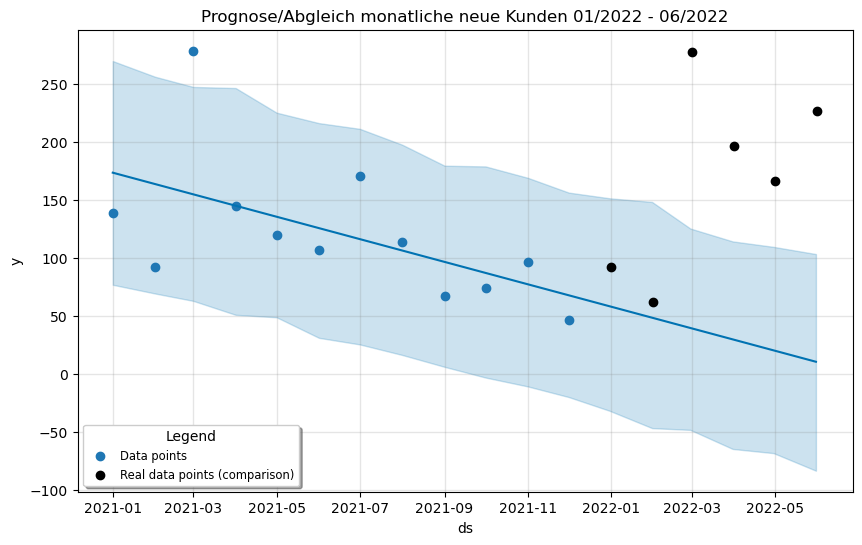

In [38]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define axes labels and title
ax.set_xlabel('Jahr-Monat')
ax.set_ylabel('Neue Kunden')
ax.set_title('Prognose/Abgleich monatliche neue Kunden 01/2022 - 06/2022')

# Enable grid
ax.grid(True, zorder=0)

# Plot the actual data points
ax.scatter(df_modell_forecast['ds'], df_modell_forecast['y'], label='Data points', zorder=2)
ax.scatter(df_modell_test['ds'], df_modell_test['y'], color="black", label='Real data points (comparison)', zorder=2)

# Plot the forecast using Prophet's plot function
model.plot(forecast, ax=ax)

# Customize the legend and confidence interval colors
handles, labels = ax.get_legend_handles_labels()
new_handles = []
new_labels = []
for handle, label in zip(handles, labels):
    if 'yhat' in label:
        new_handles.append(handle)
        new_labels.append('Forecast trend')
    elif 'yhat_lower' in label or 'yhat_upper' in label:
        new_handles.append(handle)
        new_labels.append('Uncertainty interval forecast')
    elif label == 'Data points':
        new_handles.append(handle)
        new_labels.append('Data points')
    elif label == 'Real data points (comparison)':
        new_handles.append(handle)
        new_labels.append('Real data points (comparison)')

# Add the customized legend
ax.legend(new_handles, new_labels, loc='lower left', title='Legend', fontsize='small', shadow=True, frameon=True)

# Show the plot
plt.show()

## Plotting Vorhersage und Vergleich mit Echtdaten

In [ ]:
sc.stop()

Sources:
- https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-prophet-5015928e402a
- https://www.kaggle.com/code/kakkarot/starter-hourly-energy-consumption-b71f2600-a
- https://www.youtube.com/watch?v=KvLG1uTC-KU